##Imports

In [2]:
!pip -q install pandas pyarrow matplotlib scipy tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
from datetime import date, timedelta
from tqdm import tqdm
import requests, pandas as pd, time

##API

In [3]:
# 10 localidades:
places = [
    "São Paulo, Brazil",
    "Rio de Janeiro, Brazil",
    "Curitiba, Brazil",
    "Cairo, Egypt",
    "Mumbai, India",
    "Sydney, Australia",
    "Moscow, Russia",
    "Johannesburg, South Africa",
    "Tokyo, Japan",
    "Mexico City, Mexico",
]

def geocode_place(name):
    url = "https://geocoding-api.open-meteo.com/v1/search"
    r = requests.get(url, params={"name": name, "count": 1, "language": "en", "format": "json"}, timeout=30)
    r.raise_for_status()
    data = r.json()
    if not data.get("results"):
        raise ValueError(f"Não achei coordenadas para: {name}")
    res = data["results"][0]
    return {
        "place": name,
        "name_found": res["name"],
        "country": res.get("country"),
        "latitude": res["latitude"],
        "longitude": res["longitude"]
    }

coords = pd.DataFrame([geocode_place(p) for p in places])
coords

,place,name_found,country,latitude,longitude
0,"São Paulo, Brazil",São Paulo,Brazil,-23.54750,-46.63611
1,"Rio de Janeiro, Brazil",Rio de Janeiro,Brazil,-22.90642,-43.18223
2,"Curitiba, Brazil",Curitiba,Brazil,-25.42778,-49.27306
3,"Cairo, Egypt",Cairo,Egypt,30.06263,31.24967
4,"Mumbai, India",Mumbai,India,19.07283,72.88261
5,"Sydney, Australia",Sydney,Australia,-33.86785,151.20732
6,"Moscow, Russia",Moscow,Russia,55.75222,37.61556
7,"Johannesburg, South Africa",Johannesburg,South Africa,-26.20227,28.04363
8,"Tokyo, Japan",Tokyo,Japan,35.68950,139.69171
9,"Mexico City, Mexico",Mexico City,Mexico,19.42847,-99.12766


##Download

In [4]:
# Período global
START_DATE = "2015-01-01"
END_DATE = (date.today() - timedelta(days=7)).isoformat()

# Variáveis horárias
HOURLY_VARS = ["temperature_2m", "relative_humidity_2m",
               "soil_temperature_0_to_7cm", "precipitation"]
BASE_URL = "https://archive-api.open-meteo.com/v1/era5"

# Listas para acumular resultados
all_daily_dfs, all_monthly_dfs, all_annual_dfs = [], [], []

def fetch_city_series(lat, lon, start, end):
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": ",".join(HOURLY_VARS),
        "timezone": "UTC"
    }
    r = requests.get(BASE_URL, params=params, timeout=120)
    r.raise_for_status()
    return r.json()

def to_df_from_hourly(json_obj):
    H = json_obj.get("hourly", {})
    t = pd.to_datetime(H["time"])
    df = pd.DataFrame(index=t)
    for k, v in H.items():
        if k != "time":
            df[k] = pd.to_numeric(v, errors="coerce")
    df.index.name = "datetime_utc"
    return df

def agg_daily_monthly_annual(df_hourly):
    # Diários
    daily = pd.DataFrame({
        "temperature_2m": df_hourly["temperature_2m"].resample("D").mean(),
        "relative_humidity_2m": df_hourly["relative_humidity_2m"].resample("D").mean(),
        "soil_temperature_0_to_7cm": df_hourly["soil_temperature_0_to_7cm"].resample("D").mean(),
        "precipitation_sum": df_hourly["precipitation"].resample("D").sum()
    })
    daily.index.name = "date"

    # Mensais
    monthly = pd.DataFrame({
        "temperature_2m_mean": daily["temperature_2m"].resample("MS").mean(),
        "relative_humidity_2m_mean": daily["relative_humidity_2m"].resample("MS").mean(),
        "soil_temperature_0_to_7cm_mean": daily["soil_temperature_0_to_7cm"].resample("MS").mean(),
        "precipitation_sum": daily["precipitation_sum"].resample("MS").sum()
    })

    # Anuais
    annual = pd.DataFrame({
        "temperature_2m_mean": daily["temperature_2m"].resample("YS").mean(),
        "relative_humidity_2m_mean": daily["relative_humidity_2m"].resample("YS").mean(),
        "soil_temperature_0_to_7cm_mean": daily["soil_temperature_0_to_7cm"].resample("YS").mean(),
        "precipitation_sum": daily["precipitation_sum"].resample("YS").sum()
    })

    return daily, monthly, annual

def year_blocks(start, end, step=5):
    start_year, end_year = int(start[:4]), int(end[:4])
    blocks = []
    for y in range(start_year, end_year+1, step):
        y_end = min(y+step-1, end_year)
        blocks.append((
            f"{y}-01-01",
            f"{y_end}-12-31" if y_end < end_year else end
        ))
    return blocks

# Cidades
coords = pd.DataFrame([
    {"place": "São Paulo", "country": "Brazil", "latitude": -23.5505, "longitude": -46.6333},
    {"place": "Rio de Janeiro", "country": "Brazil", "latitude": -22.9068, "longitude": -43.1729},
    {"place": "Curitiba", "country": "Brazil", "latitude": -25.4284, "longitude": -49.2733},
    {"place": "Cairo", "country": "Egypt", "latitude": 30.0444, "longitude": 31.2357},
    {"place": "Mumbai", "country": "India", "latitude": 19.0760, "longitude": 72.8777},
    {"place": "Sydney", "country": "Australia", "latitude": -33.8688, "longitude": 151.2093},
    {"place": "Moscow", "country": "Russia", "latitude": 55.7558, "longitude": 37.6173},
    {"place": "Johannesburg", "country": "South Africa", "latitude": -26.2041, "longitude": 28.0473},
    {"place": "Tokyo", "country": "Japan", "latitude": 35.6895, "longitude": 139.6917},
    {"place": "Mexico City", "country": "Mexico", "latitude": 19.4326, "longitude": -99.1332}
])

# Loop cidades
for _, row in tqdm(coords.iterrows(), total=len(coords)):
    dfs_h = []
    for start, end in year_blocks(START_DATE, END_DATE, step=5):
        j = fetch_city_series(row.latitude, row.longitude, start, end)
        dfs_h.append(to_df_from_hourly(j))
        time.sleep(60)

    df_h = pd.concat(dfs_h)

    daily, monthly, annual = agg_daily_monthly_annual(df_h)

    for df in (daily, monthly, annual):
        df["place"] = row.place
        df["country"] = row.country

    all_daily_dfs.append(daily.reset_index())
    all_monthly_dfs.append(monthly.reset_index(names="date"))
    all_annual_dfs.append(annual.reset_index(names="year"))

# Concatena e salva
daily_all = pd.concat(all_daily_dfs, ignore_index=True)
monthly_all = pd.concat(all_monthly_dfs, ignore_index=True)
annual_all = pd.concat(all_annual_dfs, ignore_index=True)

daily_all.to_csv("weather_10_cities_daily.csv", index=False)
monthly_all.to_csv("weather_10_cities_monthly.csv", index=False)
annual_all.to_csv("weather_10_cities_annual.csv", index=False)

print("✅ Dados salvos!")

100%|██████████| 10/10 [30:40<00:00, 184.03s/it]


✅ Dados salvos!


##Bronze

In [7]:
# Carrega os arquivos gerados
daily_bronze   = pd.read_csv("weather_10_cities_daily.csv", parse_dates=["date"])
monthly_bronze = pd.read_csv("weather_10_cities_monthly.csv", parse_dates=["date"])
annual_bronze  = pd.read_csv("weather_10_cities_annual.csv", parse_dates=["year"])


daily_bronze.head(), monthly_bronze.head(), annual_bronze.head()

(        date  temperature_2m  relative_humidity_2m  soil_temperature_0_to_7cm  \
 0 2015-01-01       26.025000             72.833333                  26.391667   
 1 2015-01-02       25.975000             74.166667                  26.600000   
 2 2015-01-03       22.875000             92.250000                  25.950000   
 3 2015-01-04       22.545833             89.250000                  25.466667   
 4 2015-01-05       22.100000             89.958333                  24.600000   
 
    precipitation_sum      place country  
 0                0.3  São Paulo  Brazil  
 1                7.8  São Paulo  Brazil  
 2                5.7  São Paulo  Brazil  
 3               20.9  São Paulo  Brazil  
 4                5.9  São Paulo  Brazil  ,
         date  temperature_2m_mean  relative_humidity_2m_mean  \
 0 2015-01-01            24.270565                  80.676075   
 1 2015-02-01            22.473810                  85.229167   
 2 2015-03-01            21.273522                  

##Silver

In [8]:
def ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

# Normaliza BRONZE → SILVER
daily_silver = daily_bronze.copy()
monthly_silver = monthly_bronze.copy()
annual_silver = annual_bronze.copy()


daily_silver = ensure_numeric(daily_silver, [
    "temperature_2m","relative_humidity_2m","soil_temperature_0_to_7cm","precipitation_sum"
])
monthly_silver = ensure_numeric(monthly_silver, [
    "temperature_2m_mean","relative_humidity_2m_mean","soil_temperature_0_to_7cm_mean","precipitation_sum"
])
annual_silver = ensure_numeric(annual_silver, [
    "temperature_2m_mean","relative_humidity_2m_mean","soil_temperature_0_to_7cm_mean","precipitation_sum"
])


daily_silver["year"] = daily_silver["date"].dt.year
daily_silver["month"] = daily_silver["date"].dt.month

monthly_silver["year"] = monthly_silver["date"].dt.year
monthly_silver["month"] = monthly_silver["date"].dt.month

annual_silver["year_num"] = annual_silver["year"].dt.year

# Remove duplicatas
daily_silver = daily_silver.drop_duplicates(subset=["place","country","date"])
monthly_silver = monthly_silver.drop_duplicates(subset=["place","country","date"])
annual_silver = annual_silver.drop_duplicates(subset=["place","country","year"])

daily_silver.head(), monthly_silver.head(), annual_silver.head()


(        date  temperature_2m  relative_humidity_2m  soil_temperature_0_to_7cm  \
 0 2015-01-01       26.025000             72.833333                  26.391667   
 1 2015-01-02       25.975000             74.166667                  26.600000   
 2 2015-01-03       22.875000             92.250000                  25.950000   
 3 2015-01-04       22.545833             89.250000                  25.466667   
 4 2015-01-05       22.100000             89.958333                  24.600000   
 
    precipitation_sum      place country  year  month  
 0                0.3  São Paulo  Brazil  2015      1  
 1                7.8  São Paulo  Brazil  2015      1  
 2                5.7  São Paulo  Brazil  2015      1  
 3               20.9  São Paulo  Brazil  2015      1  
 4                5.9  São Paulo  Brazil  2015      1  ,
         date  temperature_2m_mean  relative_humidity_2m_mean  \
 0 2015-01-01            24.270565                  80.676075   
 1 2015-02-01            22.473810     

##Gold

In [9]:
def linear_trend(x_years, y_values):
    """Retorna slope/ano, intercepto, R2 e slope por década."""
    mask = (~np.isnan(x_years)) & (~np.isnan(y_values))
    x = x_years[mask]
    y = y_values[mask]
    if len(x) < 3:
        return np.nan, np.nan, np.nan, np.nan
    # Regressão (y = a*x + b)
    a, b = np.polyfit(x, y, 1)
    # R2
    y_hat = a*x + b
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return a, b, r2, a*10  # slope por década

annual_gold = (
    annual_silver
    .groupby("year_num", as_index=False)
    .agg({
        "temperature_2m_mean":"mean",
        "relative_humidity_2m_mean":"mean",
        "soil_temperature_0_to_7cm_mean":"mean",
        "precipitation_sum":"mean"
    })
    .rename(columns={
        "temperature_2m_mean":"temp_air_mean_global",
        "relative_humidity_2m_mean":"rh_mean_global",
        "soil_temperature_0_to_7cm_mean":"soil_temp_mean_global",
        "precipitation_sum":"precip_total_global"
    })
)

# Tendências globais (anuais)
x = annual_gold["year_num"].values.astype(float)

trend_temp = linear_trend(x, annual_gold["temp_air_mean_global"].values)
trend_soil = linear_trend(x, annual_gold["soil_temp_mean_global"].values)
trend_rh   = linear_trend(x, annual_gold["rh_mean_global"].values)
trend_pr   = linear_trend(x, annual_gold["precip_total_global"].values)

trend_temp, trend_soil, trend_rh, trend_pr


((np.float64(0.06342922515853927),
  np.float64(-109.7759445060996),
  np.float64(0.2669392444485874),
  np.float64(0.6342922515853927)),
 (np.float64(0.08606103542076991),
  np.float64(-153.6099911323176),
  np.float64(0.4453746613391524),
  np.float64(0.8606103542076992)),
 (np.float64(-0.34466451470991555),
  np.float64(766.7468346128883),
  np.float64(0.6992153999023862),
  np.float64(-3.4466451470991553)),
 (np.float64(-2.4655454545446496),
  np.float64(6054.248181816555),
  np.float64(0.00399180162046231),
  np.float64(-24.655454545446496)))

In [10]:
# ======== GOLD MENSAL (correlação umidade x chuva) ========
#(média das cidades por mês)
monthly_gold = (
    monthly_silver
    .groupby(["year","month"], as_index=False)
    .agg({
        "temperature_2m_mean":"mean",
        "relative_humidity_2m_mean":"mean",
        "soil_temperature_0_to_7cm_mean":"mean",
        "precipitation_sum":"mean"
    })
    .rename(columns={
        "temperature_2m_mean":"temp_air_mean_global",
        "relative_humidity_2m_mean":"rh_mean_global",
        "soil_temperature_0_to_7cm_mean":"soil_temp_mean_global",
        "precipitation_sum":"precip_sum_global"
    })
)
monthly_gold["date"] = pd.to_datetime(dict(year=monthly_gold["year"], month=monthly_gold["month"], day=1))

# Correlação global mensal RH x precipitação
corr_global = monthly_gold[["rh_mean_global","precip_sum_global"]].corr().iloc[0,1]
corr_global


np.float64(0.2782334187516841)

In [11]:
# Correlação por cidade (mensal)
corr_by_city = (
    monthly_silver
    .groupby("place")
    .apply(lambda g: g[["relative_humidity_2m_mean","precipitation_sum"]].corr().iloc[0,1])
    .reset_index()
    .rename(columns={0:"corr_rh_precip"})
    .sort_values("corr_rh_precip", ascending=False)
)
corr_by_city


/tmp/ipython-input-160410523.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["relative_humidity_2m_mean","precipitation_sum"]].corr().iloc[0,1])


,place,corr_rh_precip
2,Johannesburg,0.755400
5,Mumbai,0.738088
3,Mexico City,0.659494
9,Tokyo,0.634058
1,Curitiba,0.549172
7,Sydney,0.542005
8,São Paulo,0.505843
6,Rio de Janeiro,0.437661
0,Cairo,0.380073
4,Moscow,-0.040954


###Temperatura do ar global

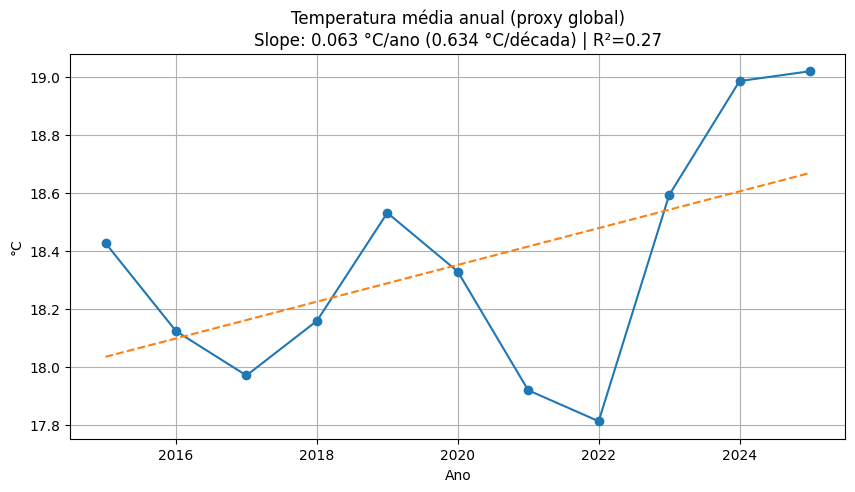

In [15]:
plt.figure(figsize=(10,5))
plt.plot(annual_gold["year_num"], annual_gold["temp_air_mean_global"], marker="o")
# Linha de tendência
a, b, r2, a_dec = trend_temp
if not np.isnan(a):
    yhat = a*annual_gold["year_num"] + b
    plt.plot(annual_gold["year_num"], yhat, linestyle="--")
    txt = f"Slope: {a:.3f} °C/ano ({a_dec:.3f} °C/década) | R²={r2:.2f}"
    plt.title("Temperatura média anual (proxy global)\n" + txt)
else:
    plt.title("Temperatura média anual (proxy global)")
plt.xlabel("Ano")
plt.ylabel("°C")
plt.grid(True)
plt.show()


###Temperatura do solo global

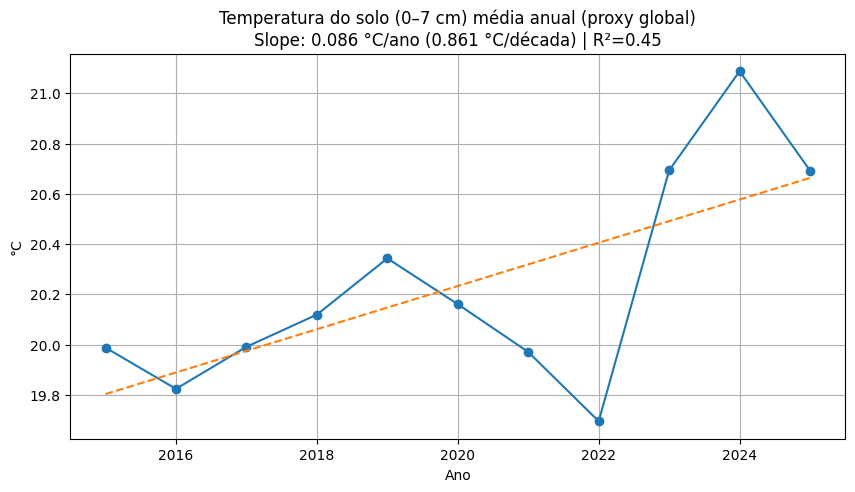

In [16]:
plt.figure(figsize=(10,5))
plt.plot(annual_gold["year_num"], annual_gold["soil_temp_mean_global"], marker="o")
a, b, r2, a_dec = trend_soil
if not np.isnan(a):
    yhat = a*annual_gold["year_num"] + b
    plt.plot(annual_gold["year_num"], yhat, linestyle="--")
    txt = f"Slope: {a:.3f} °C/ano ({a_dec:.3f} °C/década) | R²={r2:.2f}"
    plt.title("Temperatura do solo (0–7 cm) média anual (proxy global)\n" + txt)
else:
    plt.title("Temperatura do solo (0–7 cm) média anual (proxy global)")
plt.xlabel("Ano")
plt.ylabel("°C")
plt.grid(True)
plt.show()


##Umidade relativa global anual

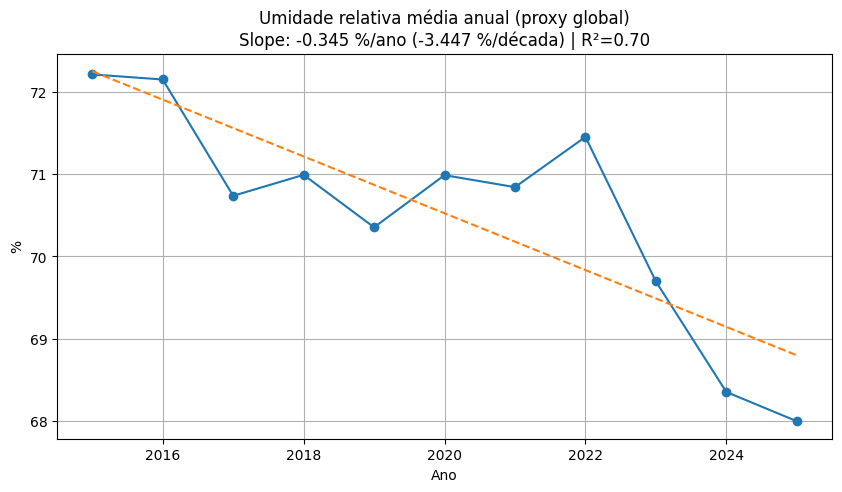

In [17]:
plt.figure(figsize=(10,5))
plt.plot(annual_gold["year_num"], annual_gold["rh_mean_global"], marker="o")
a, b, r2, a_dec = trend_rh
if not np.isnan(a):
    yhat = a*annual_gold["year_num"] + b
    plt.plot(annual_gold["year_num"], yhat, linestyle="--")
    txt = f"Slope: {a:.3f} %/ano ({a_dec:.3f} %/década) | R²={r2:.2f}"
    plt.title("Umidade relativa média anual (proxy global)\n" + txt)
else:
    plt.title("Umidade relativa média anual (proxy global)")
plt.xlabel("Ano")
plt.ylabel("%")
plt.grid(True)
plt.show()


##Precipitação anual global

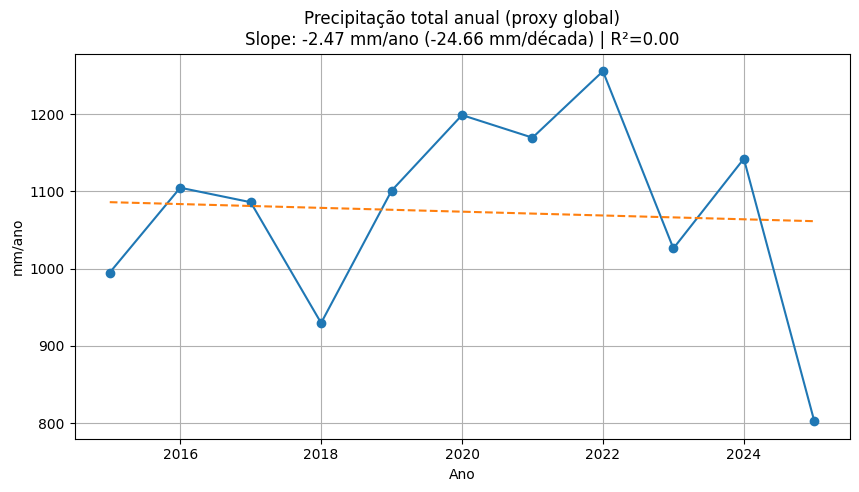

In [18]:
plt.figure(figsize=(10,5))
plt.plot(annual_gold["year_num"], annual_gold["precip_total_global"], marker="o")
a, b, r2, a_dec = trend_pr
if not np.isnan(a):
    yhat = a*annual_gold["year_num"] + b
    plt.plot(annual_gold["year_num"], yhat, linestyle="--")
    txt = f"Slope: {a:.2f} mm/ano ({a_dec:.2f} mm/década) | R²={r2:.2f}"
    plt.title("Precipitação total anual (proxy global)\n" + txt)
else:
    plt.title("Precipitação total anual (proxy global)")
plt.xlabel("Ano")
plt.ylabel("mm/ano")
plt.grid(True)
plt.show()


##Correlação mensal entre umidade e chuva

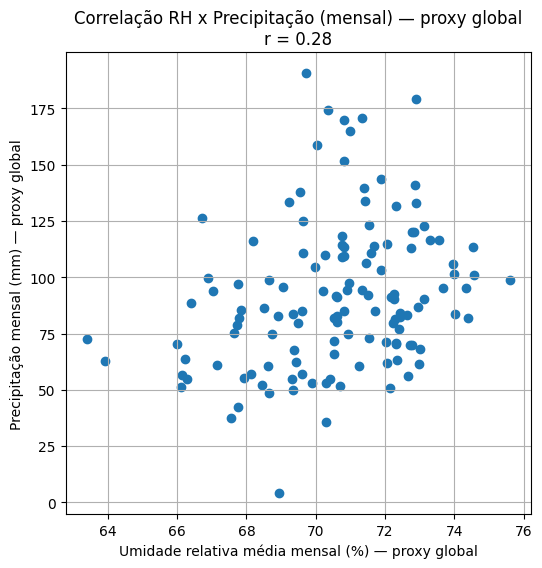

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(monthly_gold["rh_mean_global"], monthly_gold["precip_sum_global"])
plt.xlabel("Umidade relativa média mensal (%) — proxy global")
plt.ylabel("Precipitação mensal (mm) — proxy global")
plt.title(f"Correlação RH x Precipitação (mensal) — proxy global\nr = {corr_global:.2f}")
plt.grid(True)
plt.show()


##Correlação por cidade

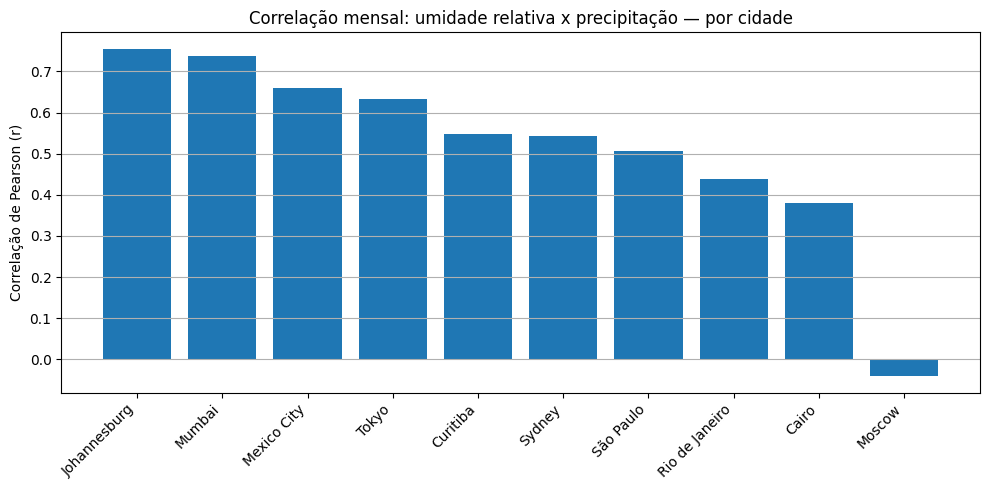

In [20]:
plt.figure(figsize=(10,5))
plt.bar(corr_by_city["place"], corr_by_city["corr_rh_precip"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Correlação de Pearson (r)")
plt.title("Correlação mensal: umidade relativa x precipitação — por cidade")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()
